In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from qdrant_client import models, QdrantClient

In [2]:
full_path = (
    "/home/kareem/Desktop/AI_Projects/drug_search_ai/drugs_side_effects_drugs_com.csv"
)

In [3]:
ds = pd.read_csv(full_path)
ds.head()

,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,X,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,NaN,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",NaN,41%,Rx,X,N,X,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.9,623.0,https://www.drugs.com/accutane.html,https://www.drugs.com/condition/acne.html
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives","Cleocin T, Clindacin ETZ, Clindacin P, Clindag...",39%,Rx,B,N,NaN,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.4,146.0,https://www.drugs.com/mtm/clindamycin-topical....,https://www.drugs.com/condition/acne.html


In [4]:
ds["drug_length"] = ds["drug_name"].apply(lambda x: len(x))

<AxesSubplot:>

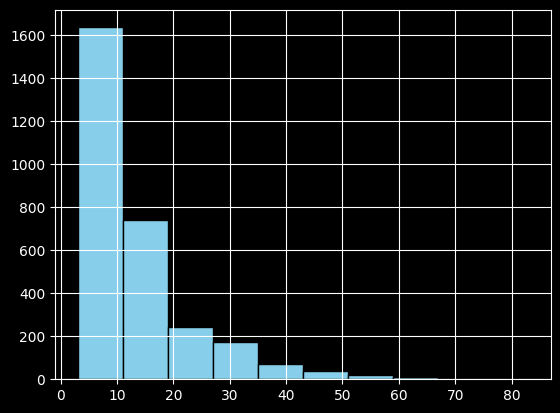

In [5]:
ds["drug_length"].hist(bins=10, color="skyblue", edgecolor="black")

In [6]:
encoder = SentenceTransformer("thenlper/gte-base",device="cuda")

In [7]:
qdrant = QdrantClient(":memory:")

In [8]:
collection_name = "drug_collection"

In [9]:
qdrant.recreate_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=encoder.get_sentence_embedding_dimension(), distance=models.Distance.COSINE
    ),
)

True

In [10]:
qdrant.upsert(
    collection_name=collection_name,
    points=[
        models.PointStruct(
            id=k,
            vector=encoder.encode(v["drug_name"]),
            payload=v.to_dict(),
        )
        for k, v in ds.iterrows()
    ],
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [11]:
# Check the collection size to make sure all the points have been stored
qdrant.count(collection_name=collection_name)

CountResult(count=2931)

In [12]:
qdrant.scroll(
    collection_name=collection_name, limit=10, with_payload=True, with_vectors=10
)

([Record(id=0, payload={'drug_name': 'doxycycline', 'medical_condition': 'Acne', 'side_effects': '(hives, difficult breathing, swelling in your face or throat) or a severe skin reaction (fever, sore throat, burning in your eyes, skin pain, red or purple skin rash that spreads and causes blistering and peeling). Seek medical treatment if you have a serious drug reaction that can affect many parts of your body. Symptoms may include: skin rash, fever, swollen glands, flu-like symptoms, muscle aches, severe weakness, unusual bruising, or yellowing of your skin or eyes. This reaction may occur several weeks after you began using doxycycline. Doxycycline may cause serious side effects. Call your doctor at once if you have: severe stomach pain, diarrhea that is watery or bloody; throat irritation, trouble swallowing; chest pain, irregular heart rhythm, feeling short of breath; little or no urination; low white blood cell counts - fever, chills, swollen glands, body aches, weakness, pale skin,

In [13]:
drug_to_search = "doxycycline"

In [14]:
results = qdrant.search(
    collection_name = collection_name,
    query_vector = encoder.encode(drug_to_search),
    limit=10
)

In [27]:
for element in results:
    payload = element.payload
    print(f"Score: {element.score}")
    print(f"Drug Name: {payload['drug_name']}")
    print(f"Medical Condition: {payload['medical_condition']}")
    print(f"Generic Name: {payload['generic_name']}")
    print(f"Drug Classes: {payload['drug_classes']}")
    print(f"Brand Names: {payload['brand_names']}")
    print(f"Activity: {payload['activity']}")
    print(f"Rx OTC: {payload['rx_otc']}")
    print(f"Pregnancy Category: {payload['pregnancy_category']}")
    print(f"CSA: {payload['csa']}")
    print(f"Alcohol: {payload['alcohol']}")
    print(f"Related Drugs: {payload['related_drugs']}")
    print(f"Medical Condition Description: {payload['medical_condition_description']}")
    print(f"Rating: {payload['rating']}")
    print(f"No. of Reviews: {payload['no_of_reviews']}")
    print(f"Drug Link: {payload['drug_link']}")
    print(f"Medical Condition URL: {payload['medical_condition_url']}")
    print("#"*50,'\n')

Score: 1.0
Drug Name: doxycycline
Medical Condition: Acne
Generic Name: doxycycline
Drug Classes: Miscellaneous antimalarials, Tetracyclines
Brand Names: Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alodox, Avidoxy, Doryx, Mondoxyne NL, Monodox, Morgidox, Okebo, Oracea, Oraxyl, Periostat Targadox, Vibramycin calcium, Vibramycin Hyclate, Vibramycin monohydrate, Vibra-Tabs
Activity: 87%
Rx OTC: Rx
Pregnancy Category: D
CSA: N
Alcohol: X
Related Drugs: amoxicillin: https://www.drugs.com/amoxicillin.html | prednisone: https://www.drugs.com/prednisone.html | albuterol: https://www.drugs.com/albuterol.html | ciprofloxacin: https://www.drugs.com/ciprofloxacin.html | azithromycin: https://www.drugs.com/azithromycin.html | cephalexin: https://www.drugs.com/cephalexin.html | metronidazole: https://www.drugs.com/metronidazole.html | metronidazole topical: https://www.drugs.com/mtm/metronidazole-topical.html | clindamycin topical: https://www.drugs.com/mtm/clindamycin-topical.html | clindamycin: http